In [1]:
# import libraries
import numpy as np
import pandas as pd
import prophet
import csv, json, argparse
from datetime import datetime
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error

In [2]:
# load data
path = 'training_data.csv'
df_data = pd.read_csv(path, header=0)
df_data['日期'] = pd.Series(df_data['日期'], dtype="string")
df_data['日期'] = pd.to_datetime(df_data['日期'], format='%Y-%m-%d')
df_data = df_data.drop(df_data.columns[-67:], axis=1)
df_data = df_data.drop(df_data.columns[1:3], axis=1)
df_data.shape

(424, 2)

In [3]:
path1 = 'training_data1.csv'
df_data1 = pd.read_csv(path1, header=0)
df_data1['日期'] = pd.to_datetime(df_data1['日期'], format='%Y-%m-%d')
df_data1['備轉容量(MW)'] = df_data1['備轉容量(萬瓩)'].apply(lambda x: 10*int(x))
df_data1 = df_data1.drop(['備轉容量(萬瓩)','備轉容量率(%)'], axis=1)
df_data1 = df_data1[-27:]
df_data1.shape

(27, 2)

In [4]:
# df_training = {'ds':df_data['日期'].add(df_data1['日期']), 'y':df_data['備轉容量(MW)']}
# df_training
df_training = pd.concat([df_data,df_data1[-27:]])
df_training

,日期,備轉容量(MW)
0,2021-01-01,2767
1,2021-01-02,2936
2,2021-01-03,3037
3,2021-01-04,3032
4,2021-01-05,3067
...,...,...
81,2022-03-23,3710
82,2022-03-24,2380
83,2022-03-25,3390
84,2022-03-26,3270


In [5]:
# preprocessing
min_max_scaler = MinMaxScaler()
df_training['備轉容量(MW)'] = pd.DataFrame(min_max_scaler.fit_transform(pd.DataFrame(df_training['備轉容量(MW)'])))
df_training.tail()

,日期,備轉容量(MW)
81,2022-03-23,0.369523
82,2022-03-24,0.285413
83,2022-03-25,0.322893
84,2022-03-26,0.324125
85,2022-03-27,0.310399


In [6]:
# make holiday data
pathHoliday2021 = '2021holiday.csv'
pathHoliday2022 = '2022holiday.csv'
h2021 = pd.read_csv(pathHoliday2021, header=0)
h2022 = pd.read_csv(pathHoliday2022, header=0)
h = pd.concat([h2021, h2022], ignore_index=True)
h = h.loc[h['是否放假']==2]
h['西元日期'] = pd.Series(h['西元日期'], dtype="string")
h['西元日期'] = pd.to_datetime(h['西元日期'], format='%Y-%m-%d')
superH = h.dropna()

playoffs = pd.DataFrame({
  'holiday': 'playoff',
  'ds': h['西元日期'],
  'lower_window': 0,
  'upper_window': 1,
})
superbowls = pd.DataFrame({
  'holiday': 'superbowl',
  'ds': superH['西元日期'],
  'lower_window': 0,
  'upper_window': 1,
})
holidays = pd.concat((playoffs, superbowls))
holidays

,holiday,ds,lower_window,upper_window
0,playoff,2021-01-01,0,1
1,playoff,2021-01-02,0,1
2,playoff,2021-01-03,0,1
8,playoff,2021-01-09,0,1
9,playoff,2021-01-10,0,1
...,...,...,...,...
459,superbowl,2022-04-05,0,1
518,superbowl,2022-06-03,0,1
616,superbowl,2022-09-09,0,1
617,superbowl,2022-09-10,0,1


In [7]:
#build Prophet model
d = {'ds':df_training['日期'],'y':df_training['備轉容量(MW)']}
train = pd.DataFrame(data=d)
model = prophet.Prophet(holidays = holidays,yearly_seasonality=True,daily_seasonality=True)
model.fit(train)

In [8]:
# define testing data
predict_date = list()
for i in range(30,32):
    predict_date.append(datetime.strptime(f'2021-03-{i}', '%Y-%m-%d'))
for i in range(1,14):
    predict_date.append(datetime.strptime(f'2021-04-{i}', '%Y-%m-%d'))
predict_date = pd.DataFrame(predict_date, columns=['ds'])
predict_date['ds']= pd.to_datetime(predict_date['ds'])
predict_date

,ds
0,2021-03-30
1,2021-03-31
2,2021-04-01
3,2021-04-02
4,2021-04-03
5,2021-04-04
6,2021-04-05
7,2021-04-06
8,2021-04-07
9,2021-04-08


In [9]:
# prediction
forecast = model.predict(predict_date)
# inverse normolization
forecast['yhat'] = pd.DataFrame(min_max_scaler.inverse_transform(pd.DataFrame(forecast['yhat'])))
forecast = forecast.drop(forecast.columns[1:30], axis=1)
forecast

,ds,yhat
0,2021-03-30,3041.633606
1,2021-03-31,3005.642288
2,2021-04-01,3104.486625
3,2021-04-02,3529.447786
4,2021-04-03,3138.804487
5,2021-04-04,3024.898056
6,2021-04-05,3002.348676
7,2021-04-06,2874.986288
8,2021-04-07,2983.154915
9,2021-04-08,3097.603112


In [10]:
# output submission.csv
output_filename = 'submission.csv'
f = open(output_filename,'w',newline='')
w = csv.writer(f)
w.writerow(['date','operating_reserve(MW)'])
for data in forecast.values:
    date = data[0].strftime("%Y%m%d")
    w.writerow([date, np.round(data[1])])

In [31]:
# Evaluation
Tpredict = pd.DataFrame({ # 未來一周台電預測值
            'ds': ['2022-03-30', '2022-03-31', '2022-04-01', '2022-04-02', '2022-04-03', '2022-04-04', '2022-04-05'],
            'y': [3150, 3780, 4450, 3420, 3700, 3720, 3970]
            })
mean_absolute_error(Tpredict['y'],forecast['yhat'][:7])

651.6620068878074

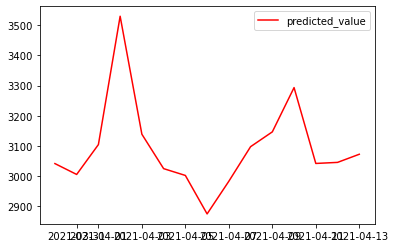

In [30]:
plt.plot(forecast['ds'], forecast['yhat'], color='red', label='predicted_value')
# plt.plot(forecast['ds'][:7], Tpredict['y'], color='blue', label='taipower predict')
plt.legend()
plt.show()